In [1]:
import os
from urllib import request 
from collections import defaultdict
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
import pandas as pd

mpl.rcParams["font.size"] = 13
mpl.rcParams['figure.dpi'] = 120

In [2]:
def download_data(name_dir="data", filename="data.csv",
                  data_url = 'https://www2.census.gov/programs-surveys/popest/datasets/2010-2017/cities/totals/sub-est2017_42.csv'):
    """ 
    Download both train and test dataset to a directory named "data". 

    If the directory doesn't exist, this function will create one. 

    Parameters
    ----------
    url : str
    The URL of the location of the file.

    Returns
    -------
    No return. Create a directory if needed and 
    download the file to that directory.
    """
    
    if not os.path.isdir(name_dir):
        os.makedirs(name_dir)

    data_path = os.path.join(name_dir, filename)

    request.urlretrieve(data_url,data_path)
    
def GEOID_ten(x):
    """
    Convert 12-digit geoid to 10-digit.
    
    More details can be found at https://www.census.gov/geo/reference/geoidentifiers.html.
    Parameters
    ----------
    x : int
    
    Returns
    -------
    int
    
    """
    
    astr = str(x)[:10]
    return int(astr)

## Download Sub-county population dataset for PA

In [13]:
# https://www.census.gov/data/datasets/2017/demo/popest/total-cities-and-towns.html
url_pop = 'https://www2.census.gov/programs-surveys/popest/datasets/2010-2017/cities/totals/sub-est2017_42.csv'

In [17]:
download_data(name_dir="data", 
              filename="population.csv",
              data_url=url_pop)

## Download population data from US Census

In [18]:
url_ems = 'https://data.wprdc.org/dataset/abba9671-a026-4270-9c83-003a1414d628/resource/ff33ca18-2e0c-4cb5-bdcd-60a5dc3c0418/download/911-ems-dispatches.csv'

In [22]:
download_data(name_dir="data", 
              filename="EMS.csv",
              data_url=url_ems)

In [23]:
df_ems = pd.read_csv('data/EMS.csv')
df_ems.head()


,Call_ID_Hash,SERVICE,PRIORITY,PRIORITY_DESC,AGENCY,CALL_QUARTER,CALL_YEAR,DESCRIPTION_SHORT,CITY_CODE,CITY_NAME,GEOID
0,336ba345f5a0,EMS,E0,EMS ALS life threatening response w/ backup,E620,Q1,2015,HEMORRHAGE,PVU,PORT VUE,420035003002
1,f59d50d394fa,EMS,E0,EMS ALS life threatening response w/ backup,E380,Q1,2015,UNCONSCIOUS,PEN,PENN HILLS,420035235011
2,8d56b4f6f9fe,EMS,E0,EMS ALS life threatening response w/ backup,E620,Q1,2015,UNCONSCIOUS,MCK,MCKEESPORT,420035523003
3,e20045d2f6b4,EMS,E0,EMS ALS life threatening response w/ backup,E050,Q1,2015,"GUNSHOT, STABBING, OR OTHER WOUND",PGH,PITTSBURGH,420031306003
4,dbe1c9db46f6,EMS,E0,EMS ALS life threatening response w/ backup,E050,Q1,2015,ASSAULT,PGH,PITTSBURGH,420031609002


In [21]:
df_pop = pd.read_csv('data/population.csv')
df_pop.head()

,SUMLEV,STATE,COUNTY,PLACE,COUSUB,CONCIT,PRIMGEO_FLAG,FUNCSTAT,NAME,STNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017
0,40,42,0,0,0,0,0,A,Pennsylvania,Pennsylvania,12702379,12702857,12711063,12742811,12768034,12778450,12790341,12791124,12787085,12805537
1,162,42,0,116,0,0,0,A,Abbottstown borough,Pennsylvania,1011,1011,1010,1011,1008,1006,1009,1012,1013,1020
2,162,42,0,332,0,0,0,A,Adamsburg borough,Pennsylvania,172,172,172,171,170,169,168,167,165,164
3,162,42,0,364,0,0,0,A,Adamstown borough,Pennsylvania,1789,1789,1801,1835,1837,1839,1844,1845,1847,1850
4,162,42,0,396,0,0,0,A,Addison borough,Pennsylvania,207,207,207,205,204,202,201,198,198,197


In [61]:
df_pop['NAME_UP'] = df_pop['NAME'].str.upper()
df_pop.head()


,SUMLEV,STATE,COUNTY,PLACE,COUSUB,CONCIT,PRIMGEO_FLAG,FUNCSTAT,NAME,STNAME,...,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,NAME_UP
0,40,42,0,0,0,0,0,A,Pennsylvania,Pennsylvania,...,12702857,12711063,12742811,12768034,12778450,12790341,12791124,12787085,12805537,PENNSYLVANIA
1,162,42,0,116,0,0,0,A,Abbottstown borough,Pennsylvania,...,1011,1010,1011,1008,1006,1009,1012,1013,1020,ABBOTTSTOWN BOROUGH
2,162,42,0,332,0,0,0,A,Adamsburg borough,Pennsylvania,...,172,172,171,170,169,168,167,165,164,ADAMSBURG BOROUGH
3,162,42,0,364,0,0,0,A,Adamstown borough,Pennsylvania,...,1789,1801,1835,1837,1839,1844,1845,1847,1850,ADAMSTOWN BOROUGH
4,162,42,0,396,0,0,0,A,Addison borough,Pennsylvania,...,207,207,205,204,202,201,198,198,197,ADDISON BOROUGH


In [121]:
df_ems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780698 entries, 0 to 780697
Data columns (total 13 columns):
Call_ID_Hash         780698 non-null object
SERVICE              780698 non-null object
PRIORITY             780698 non-null object
PRIORITY_DESC        780698 non-null object
AGENCY               780698 non-null object
CALL_QUARTER         780698 non-null object
CALL_YEAR            780698 non-null int64
DESCRIPTION_SHORT    778103 non-null object
CITY_CODE            780698 non-null object
CITY_NAME            780698 non-null object
GEOID                780698 non-null int64
GEOID_10             780698 non-null int64
GEOID_5              780698 non-null int64
dtypes: int64(4), object(9)
memory usage: 77.4+ MB


In [170]:
def getCodeName(geoid,df):
    """
    Return city name and city code for a given geioid.
    
    Parameters
    ----------
    geoid : int
    df : DataFrame
    
    Returns
    -------
    tuple
    """
    temp = df[(df_ems.GEOID == geoid) & (df.CITY_NAME.notnull()) ][['CITY_CODE','CITY_NAME']]
    city_name = temp['CITY_NAME'].value_counts().index[0]
    city_code = temp[ temp['CITY_NAME'] == city_name]['CITY_CODE'].value_counts().index[0]
#     print(city_name,city_code)
    return city_name,city_code

def nested_dict():
  """
  This returns a empty nestable dictionary.
  """
  return defaultdict(nested_dict)




In [118]:
getCodeName(420035629002,df_ems)

('PITTSBURGH', 'PGH')

In [109]:
# Create a backup copy
df_ems_bk = df_ems.copy()

In [115]:
# Get index for missing values at CITY_CODE and CITY_NAME
index_for_missing_values = df_ems[(df_ems.CITY_NAME.isnull()) | (df_ems.CITY_CODE.isnull())].index.tolist()
index_for_missing_values[:10]

[7200, 7237, 29818, 45426, 51944, 69156, 104522, 104614, 107710, 114511]

In [119]:
# Fill the missing values
for index in index_for_missing_values:
    geoid = df_ems.loc[index,'GEOID']
    ct_name, ct_code = getCodeName(geoid,df_ems)
    
    df_ems.loc[index,'CITY_NAME'] = ct_name
    df_ems.loc[index,'CITY_CODE'] = ct_code

# Recheck missing at CITY_CODE and CITY_NAME
df_ems[(df_ems.CITY_NAME.isnull()) | (df_ems.CITY_CODE.isnull())].index.tolist()


[]

In [122]:
df_ems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780698 entries, 0 to 780697
Data columns (total 13 columns):
Call_ID_Hash         780698 non-null object
SERVICE              780698 non-null object
PRIORITY             780698 non-null object
PRIORITY_DESC        780698 non-null object
AGENCY               780698 non-null object
CALL_QUARTER         780698 non-null object
CALL_YEAR            780698 non-null int64
DESCRIPTION_SHORT    778103 non-null object
CITY_CODE            780698 non-null object
CITY_NAME            780698 non-null object
GEOID                780698 non-null int64
GEOID_10             780698 non-null int64
GEOID_5              780698 non-null int64
dtypes: int64(4), object(9)
memory usage: 77.4+ MB


In [128]:
df_ems[df_ems.DESCRIPTION_SHORT.isnull()]['PRIORITY_DESC'].value_counts()

EMS Admin Mark out                             2491
EMS ALS life threatening response                31
EMS Standard BLS response                        31
EMS Standard ALS response                        21
EMS ALS life threatening response w/ backup      12
EMS BLS Assistance response                       8
Fire Notifications                                1
Name: PRIORITY_DESC, dtype: int64

In [134]:
df_ems['DESCRIPTION_SHORT'].fillna('MISSING',inplace=True)

In [135]:
df_ems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780698 entries, 0 to 780697
Data columns (total 13 columns):
Call_ID_Hash         780698 non-null object
SERVICE              780698 non-null object
PRIORITY             780698 non-null object
PRIORITY_DESC        780698 non-null object
AGENCY               780698 non-null object
CALL_QUARTER         780698 non-null object
CALL_YEAR            780698 non-null int64
DESCRIPTION_SHORT    780698 non-null object
CITY_CODE            780698 non-null object
CITY_NAME            780698 non-null object
GEOID                780698 non-null int64
GEOID_10             780698 non-null int64
GEOID_5              780698 non-null int64
dtypes: int64(4), object(9)
memory usage: 77.4+ MB


In [177]:
ct_names = df_ems.CITY_NAME.unique().tolist()
ct_names[:10]

['PORT VUE',
 'PENN HILLS',
 'MCKEESPORT',
 'PITTSBURGH',
 'ROSS',
 'SOUTH FAYETTE',
 'FRANKLIN PARK',
 'DUQUESNE',
 'PITCAIRN',
 'WEST MIFFLIN']

In [220]:
# Check Westmoreland county in city names
df_ems[df_ems.CITY_NAME.isin(['WESTMORELAND COUNTY'])]

,Call_ID_Hash,SERVICE,PRIORITY,PRIORITY_DESC,AGENCY,CALL_QUARTER,CALL_YEAR,DESCRIPTION_SHORT,CITY_CODE,CITY_NAME,GEOID,GEOID_10,GEOID_5
211893,eb764b289f44,EMS,E1,EMS ALS life threatening response,E590,Q4,2015,COMMERCIAL OR APARTMENT BLDG FIRE,WST,WESTMORELAND COUNTY,420034961023,4200349610,49610


In [221]:
# Drop westmoreland county
print("No. of rows before dropping = ", len(df_ems))
df_ems.drop(df_ems[df_ems.CITY_NAME.isin(['WESTMORELAND COUNTY'])].index, inplace=True)
print("No. of rows after dropping = ", len(df_ems))

No. of rows before dropping =  780698
No. of rows after dropping =  780697


In [223]:
# Rebuild the city name list
ct_names = df_ems.CITY_NAME.unique().tolist()

In [144]:
df_pop.head()

,SUMLEV,STATE,COUNTY,PLACE,COUSUB,CONCIT,PRIMGEO_FLAG,FUNCSTAT,NAME,STNAME,...,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,NAME_UP
0,40,42,0,0,0,0,0,A,Pennsylvania,Pennsylvania,...,12702857,12711063,12742811,12768034,12778450,12790341,12791124,12787085,12805537,PENNSYLVANIA
1,162,42,0,116,0,0,0,A,Abbottstown borough,Pennsylvania,...,1011,1010,1011,1008,1006,1009,1012,1013,1020,ABBOTTSTOWN BOROUGH
2,162,42,0,332,0,0,0,A,Adamsburg borough,Pennsylvania,...,172,172,171,170,169,168,167,165,164,ADAMSBURG BOROUGH
3,162,42,0,364,0,0,0,A,Adamstown borough,Pennsylvania,...,1789,1801,1835,1837,1839,1844,1845,1847,1850,ADAMSTOWN BOROUGH
4,162,42,0,396,0,0,0,A,Addison borough,Pennsylvania,...,207,207,205,204,202,201,198,198,197,ADDISON BOROUGH


In [171]:
temp_dict = nested_dict()

In [216]:
def get_pop(ct_name, df, name_col, yr_st, yr_end):
    columns=['POPESTIMATE{yr}'.format(yr=str(yr)) 
             for yr in range(yr_st, yr_end+1)]
    ct_ext = ['BOROUGH', 'CITY', 'TOWNSHIP', 'MUNICIPALITY']
    if ct_name.endswith(('BOROUGH', 'CITY', 'TOWNSHIP', 'BORO')):
        alist = ct_name.split()
        ct_name = ' '.join(alist[:-1])
    if 'CLAIR' in ct_name:
        ct_name = ct_name.replace('ST ', 'ST. ')
    ct_names = ['{name} {ext}'.format(name=ct_name, ext=ext) 
                for ext in ct_ext]
    return (df[(df[name_col]
                .isin(ct_names))][columns]
            .median().astype('int').tolist())
    

In [183]:
get_pop('SOUTH FAYETTE',df_pop,'NAME_UP',2015,2017)

[15423, 15511, 15614]

In [212]:
def get_pop_dict(ct_names, df, name_col, yr_st, yr_end):
    pop_dict = nested_dict()
    for ct_name in ct_names:
        try:
            pops = get_pop(ct_name, df, name_col, yr_st, yr_end)
            for yr,pop in zip(range(yr_st,yr_end+1), pops):
                pop_dict[ct_name][yr]=pop
        except ValueError:
            print(ct_name)
            return ct_name
    return pop_dict

In [224]:
pop_dict = get_pop_dict(ct_names,df_pop,'NAME_UP',2015,2017)
pop_dict

defaultdict(<function __main__.nested_dict()>,
            {'PORT VUE': defaultdict(<function __main__.nested_dict()>,
                         {2015: 3753, 2016: 3725, 2017: 3700}),
             'PENN HILLS': defaultdict(<function __main__.nested_dict()>,
                         {2015: 41875, 2016: 41563, 2017: 41291}),
             'MCKEESPORT': defaultdict(<function __main__.nested_dict()>,
                         {2015: 19509, 2016: 19369, 2017: 19245}),
             'PITTSBURGH': defaultdict(<function __main__.nested_dict()>,
                         {2015: 304453, 2016: 305017, 2017: 302407}),
             'ROSS': defaultdict(<function __main__.nested_dict()>,
                         {2015: 5774, 2016: 5763, 2017: 5805}),
             'SOUTH FAYETTE': defaultdict(<function __main__.nested_dict()>,
                         {2015: 15423, 2016: 15511, 2017: 15614}),
             'FRANKLIN PARK': defaultdict(<function __main__.nested_dict()>,
                         {2015: 14330,

In [226]:
df_city_count = df_ems['CITY_NAME'].value_counts().reset_index()
df_city_count.head()

,index,CITY_NAME
0,PITTSBURGH,250676
1,MCKEESPORT,27228
2,PENN HILLS,26626
3,MOUNT LEBANON,23044
4,ROSS,19019


In [254]:
df_city_count =df_ems['CITY_NAME'].value_counts().reset_index()
df_city_count.columns = ['CITY_NAME', 'NO. OF CALLS']
df_city_count['PERCENTAGE'] = round(df_city_count['NO. OF CALLS']/
                                    df_city_count['NO. OF CALLS'].sum()*
                                    100,2)
df_city_count[df_city_count['PERCENTAGE']>0.5]['PERCENTAGE'].sum()

86.25000000000003

In [286]:
def get_pop(x, **kwargs):
    pop_dict = kwargs['pop_dict']
    yr = kwargs['yr']
    return pop_dict[x][yr]

In [292]:
df_city_count['Population_2015'] = (df_city_count['CITY_NAME']
                               .apply(get_pop, pop_dict=pop_dict, yr = 2015))

In [294]:
# df_city_count.drop(inplace=True,columns= ['Population'],axis=1)
df_city_count.head()

,CITY_NAME,NO. OF CALLS,PERCENTAGE,Population_2015
0,PITTSBURGH,250676,32.11,304453
1,MCKEESPORT,27228,3.49,19509
2,PENN HILLS,26626,3.41,41875
3,MOUNT LEBANON,23044,2.95,32789
4,ROSS,19019,2.44,5774


In [295]:
df_city_count['CALL_PER_POP'] = (df_city_count['NO. OF CALLS']/
                                 df_city_count['Population_2015'])
df_city_count.head()

,CITY_NAME,NO. OF CALLS,PERCENTAGE,Population_2015,CALL_PER_POP
0,PITTSBURGH,250676,32.11,304453,0.823365
1,MCKEESPORT,27228,3.49,19509,1.395664
2,PENN HILLS,26626,3.41,41875,0.635845
3,MOUNT LEBANON,23044,2.95,32789,0.702797
4,ROSS,19019,2.44,5774,3.293904


In [297]:
df_city_count.sort_values(by=['CALL_PER_POP','Population_2015'],ascending=False)

,CITY_NAME,NO. OF CALLS,PERCENTAGE,Population_2015,CALL_PER_POP
18,HARRISON,7721,0.99,1011,7.636993
43,PINE,4183,0.54,744,5.622312
30,ELIZABETH TOWNSHIP,6389,0.82,1504,4.248005
35,RICHLAND,5326,0.68,1567,3.398851
4,ROSS,19019,2.44,5774,3.293904
9,SCOTT,11884,1.52,4820,2.465560
29,HOMESTEAD,6403,0.82,3128,2.046995
45,BRADDOCK,4174,0.53,2134,1.955951
63,EAST PITTSBURGH,2859,0.37,1800,1.588333
59,RANKIN,3220,0.41,2097,1.535527


In [256]:
s

London      20
New York    21
Helsinki    12
dtype: int64

In [279]:
def square_mul(x, **kwargs):
    adict = kwargs['custom2']
    val = x * adict['x']
    return val

In [280]:
adict={'x': -10} 

In [281]:
s.apply(square_mul,custom2=adict)

London     -200
New York   -210
Helsinki   -120
dtype: int64

In [253]:
len(temp['NO. OF CALLS'])

129

<IPython.core.display.Javascript object>


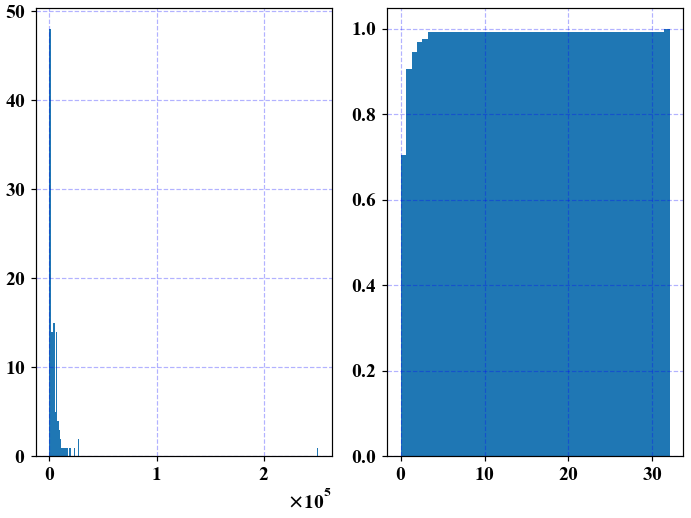

In [249]:
fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True)
temp['NO. OF CALLS'].hist(bins=200, ax= ax1)
temp['PERCENTAGE'].hist(cumulative=True, density=100, bins=50, ax = ax2)


In [299]:
df = pd.DataFrame({'lev1': [1, 1, 1, 1, 2, 2, 2, 2],
                'lev2': [1, 1, 2, 2, 1, 1, 2, 2],
                'lev3': [1, 2, 1, 2, 1, 2, 1, 2],
                'values': [0, 1, 2, 3, 4, 5, 6, 7]})

In [306]:
index=['lev1', 'lev2']
# index='lev1'

In [301]:
df['lev1']

0    1
1    1
2    1
3    1
4    2
5    2
6    2
7    2
Name: lev1, dtype: int64

In [304]:
pd.MultiIndex.from_arrays([df['lev1'], df[columns]])


MultiIndex(levels=[[1, 2], [1, 2]],
           labels=[[0, 0, 0, 0, 1, 1, 1, 1], [0, 1, 0, 1, 0, 1, 0, 1]],
           names=['lev1', 'lev3'])

In [302]:
columns='lev3'

In [309]:
indexes = [df[column] for column in index]
indexes.append(df[columns])
pd.MultiIndex.from_arrays(indexes)

MultiIndex(levels=[[1, 2], [1, 2], [1, 2]],
           labels=[[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 1, 1, 0, 0, 1, 1], [0, 1, 0, 1, 0, 1, 0, 1]],
           names=['lev1', 'lev2', 'lev3'])

In [310]:
values='values'

In [313]:
df._constructor(df[values].values, index=index)

ValueError: Shape of passed values is (1, 8), indices imply (1, 2)

In [316]:
type(pd.unique(pd.Series([2, 1, 3, 3])))

numpy.ndarray

In [318]:
type(pd.unique(pd.Series([pd.Timestamp('20160101'),
                    pd.Timestamp('20160101')])))

numpy.ndarray

In [319]:
pwd

'/Users/thein/hacktoberfest/temp'